4주차
===

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from PIL import Image as PILImage
from io import BytesIO

def notebook_dp_image(path: str, dim: set) -> None:
    img = PILImage.open(path)
    resized_img = img.resize(dim)  # (Width, Height)
    buffer = BytesIO()
    resized_img.save(buffer, format='PNG')
    display(Image(data=buffer.getvalue()))

_p106~146까지_

# 신경망 학습

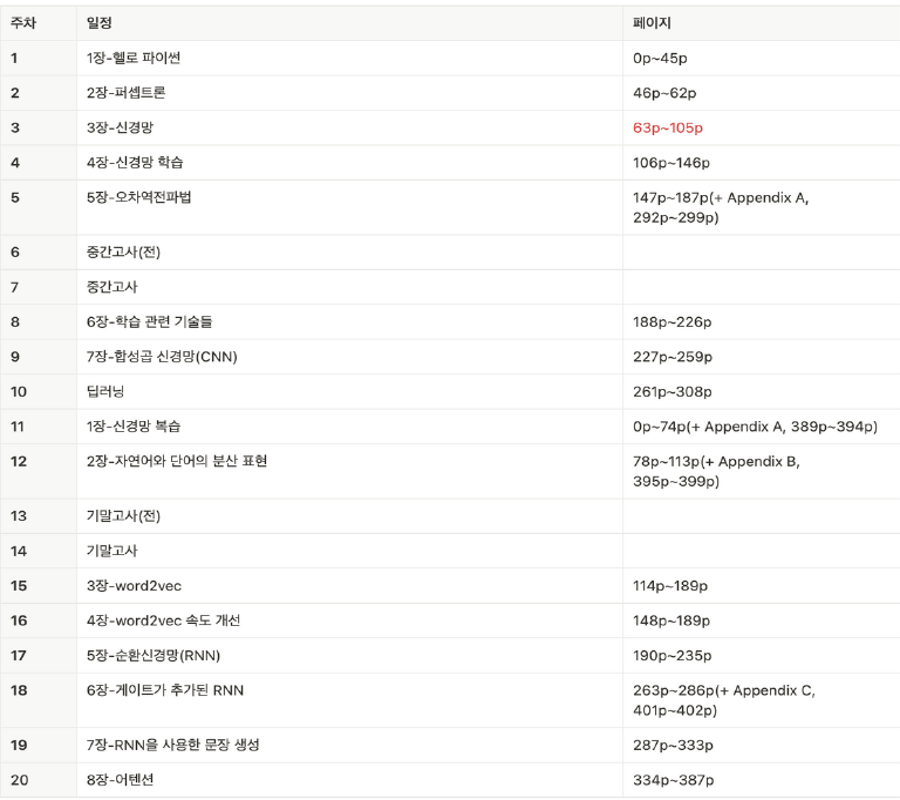

In [3]:
notebook_dp_image('./images/curriculum.png', (900,800))

---

### 데이터로만 학습하는 딥러닝

TLDR; 사람이 항상 개입하던 기존의 알고리즘 구현방식과 달리 딥러닝은 모델이 처음부터 끝까지 (end-to-end) 다 학습하는 방법

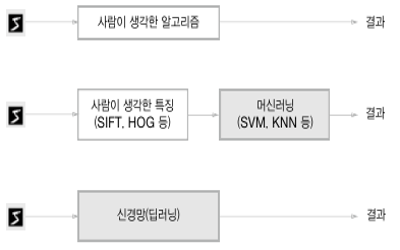

In [10]:
notebook_dp_image('./images/W4/img1.png', (400,250))

### 손실함수
#### 오차제곱합
**Sum Squares Error (SSE)**
$$
E = \frac{1}{2}\sum(y_k-t_k)^2
$$
where: 
- $y_k=prediction$
- $t_k=answer$

가장 많이 쓰이고 비교적 단순/직관적

저번의 예시를 들자면 최종 레이어인 소프트맥스 함수의 결과에서 나오는 값이다. 파이썬에서는 `ndarray`으로 나오겠죠?

In [11]:
def sum_squares_error(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    return .5 * np.sum((y - t) ** 2)

In [26]:
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ])
y = np.array([0.1, 0.05, 0.6, 0, 0.05, 0.1, 0, 0.1, 0, 0, ])
sum_squares_error(y, t)

np.float64(0.09750000000000003)

### 교차 엔트로피 오차
**Cross Entropy Error (CEE)**
$$
E=-\sum\limits_{k}^{} t_k \log y_k
$$

note:
- $\log$의 지수는 자연로그(e)임!
- $t_k$는 one-hot encoding 되어있음.

/tmp/ipykernel_8258/1743707760.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x))


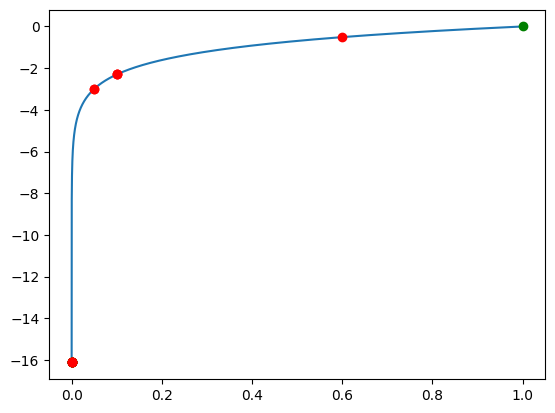

In [28]:
x = np.arange(0, 1, 1e-7)

eps = 1e-7 # zero div. error 해결용
t_ = t + eps
y_ = y + eps

plt.plot(x, np.log(x))
plt.plot(t_, np.log(t_), 'go')
plt.plot(y_, np.log(y_), 'ro')

plt.show()

In [29]:
def cross_entropy_error(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [30]:
cross_entropy_error(y, t)

np.float64(0.510825457099338)

---

### 미니배치 (mini batch)

실제 DL을 할 경우, 많은 양의 데이터를 상대로 검증해야할 수도 있음, 이때 여러 batch로 쪼개서 검증을 할수도 있는데 이 경우네 mini batch쓰는거임.

이런 경우 CCE도 이렇게 변함 (N은 총 sample의 개수)
$$
E=-\frac{1}{N}\sum\limits_{n}^{} \sum\limits_{k}^{} t_k \log y_k
$$

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# MNIST data
(x_train, t_train), (x_test, t_test) = mnist.load_data()
(x_train.shape, t_train.shape)

((60000, 28, 28), (60000,))

In [35]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
batch_mask

array([43335, 27085, 53265, 39785, 33539, 44170,  5983, 38620, 10200,
        3071])

위 처럼 랜덤 선택을 통한 마스크 생성

In [36]:
# index based filtering
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

위의 batch CEE바탕으로 함수제작

아래는 one-hot encoding일 경우
(aka. categorical cross entrophy)

In [39]:
def cross_entropy_error(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = t.reshape(1, y.size)
    
    batch_size = y.shape[0]

    return -np.sum(t * np.log(y + 1e-7)) / batch_size


아래는 숫자 label(index)일 경우 
(aka. <u>sparse</u> categorical cross entropy)

In [85]:
def sp_cross_entropy_error(y: np.ndarray, t: np.ndarray) -> np.ndarray:
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = t.reshape(1, y.size)
    
    batch_size = y.shape[0]

    print(y)
    print()
    print(f'batch_size: {batch_size}\ny[{np.arange(batch_size)}, {t}]')
    [print(f'({x_}, {y_}) -> {y[x_, y_]}') for x_, y_ in zip(np.arange(batch_size), t)]
    print(f'result => {y[np.arange(batch_size), t]}')

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


꽤나 중요한 기법인 [Advanced Integer Indexing](https://www.tutorialspoint.com/numpy/numpy_advanced_indexing.htm)

syntax는 다음과 같음
- `target_array[List[row idx to select], List[col idx to select]]`
- `target_array[List[List[...], List[...]...], List[List[...], List[...]...]]` -> can be nested!!

결론적으로 `-np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size`에서...
- `np.arange(batch_size)` = 모든 행(샘플) 일단 선택
- `t` = 각 행(샘플)별 true한 index에 해당하는 값만 반환

In [86]:
y_small = np.array([
    [0.1, 0.8, 0.1],  # Predictions for sample 0
    [0.3, 0.4, 0.3],  # Predictions for sample 1
    [0.2, 0.2, 0.6]   # Predictions for sample 2
])

# For...
# sample 0, true class is 1;
# sample 1, true class is 0;
# sample 2, true class is 2.
t_small = np.array([1, 0, 2])

sp_cross_entropy_error(y_small, t_small)

[[0.1 0.8 0.1]
 [0.3 0.4 0.3]
 [0.2 0.2 0.6]]

batch_size: 3
y[[0 1 2], [1 0 2]]
(0, 1) -> 0.8
(1, 0) -> 0.3
(2, 2) -> 0.6
result => [0.8 0.3 0.6]


np.float64(0.645980451468738)

---

### 왜 손실함수를 쓰는가?

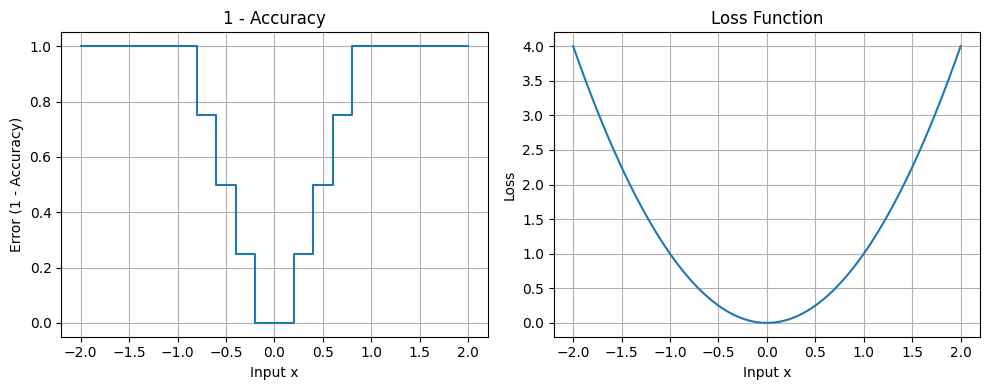

In [94]:
x = np.linspace(-2, 2, 400)

# 정확도 사용할 경우
conditions = [
    np.abs(x) < 0.2,
    (np.abs(x) >= 0.2) & (np.abs(x) < 0.4),
    (np.abs(x) >= 0.4) & (np.abs(x) < 0.6),
    (np.abs(x) >= 0.6) & (np.abs(x) < 0.8),
    np.abs(x) >= 0.8
]
values = [0, 0.25, 0.5, 0.75, 1]
y_accuracy = np.select(conditions, values, default=1)

# 손실함수를 사용할경우
y_loss = x**2

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.step(x, y_accuracy, where='mid')
plt.title("1 - Accuracy")
plt.xlabel("Input x")
plt.ylabel("Error (1 - Accuracy)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, y_loss)
plt.title("Loss Function")
plt.xlabel("Input x")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


인풋 `-2 < x < 2`인 함수에서 `x = 0`이 답이라고 가정하고 샘플 10개가 모여있다 가정하면 다음과 같은 그래프가 대충 나올 것이다.

왼쪽의 정확도를 사용한다면 샘플 하나씩 맞을때마다 오류가 떨어지며 계단모양이 되어서 x예측값이 선반 위에 있을 경우 모델은 어느방향으로 가야 성능 개선되는지 알 수 없음. 반면 오른쪽의 손실함수를 사용한 모델은 매끄럽게 내려가는 모양이라 미적해서 오류 최저값으로 경사하강 가능함! 